In [105]:
import numpy as np
import os
import arc
import importlib
importlib.reload(arc)
import json
import pandas as pd
import pickle


shelf_name='brunt-riiser-ekstrom'

# atl06_file_name = './atl06_' + shelf_name + '.pkl'
# atl06_file_name = '/home/bradlipovsky/notebooks/brunt-is2-rifts/atl06_' + shelf_name + '.pkl'
atl06_file_name = '/data/fast1/arc/atl06_' + shelf_name + '.pkl'
# atl06_filelist = './filelists/' + shelf_name + '-list.json'
# dataset_path = '/data/fast0/'


# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)
    print('ATL06 data loaded from pickle.')

# ATL06 quality flags 0: No problem 1: Problem    

display(atl06_data.loc[40])

lat = row["lat"]
lon = row["lon"]
print(len(lon))
print(lon[1])
print(lat[1])
print(lon[len(lon)-1])
print(lat[len(lat)-1])




ATL06 data loaded from pickle.


x          [-454024.67383270594, -454032.82386449946, -45...
y          [1787260.0657539228, 1787277.5525110685, 17872...
x_atc      [31983231.04154289, 31983250.946893923, 319832...
h          [92.744896, 92.64545, 92.68037, 92.66612, 92.6...
lat        [-73.14588208776458, -73.14571123225751, -73.1...
lon        [-14.253566856774114, -14.253678514241784, -14...
azimuth    [-8.071938, -8.071874, -8.071811, -8.071748, -...
quality    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
geoid      [5.890827, 5.8919487, 5.893068, 5.8941975, 5.8...
h_sig      [0.020724637, 0.019774776, 0.01896736, 0.01980...
rgt                                                    565.0
time                        2018-11-04 15:53:02.276447+00:00
beam                                                      3r
tides      [--, --, --, --, --, --, --, --, --, --, --, -...
Name: 40, dtype: object

5586
-14.253678514241784
-73.14571123225751
-14.874328692264669
-72.12603048276517


[(3878, 3889), (4562, 4563)]


(0.0, 100.0)

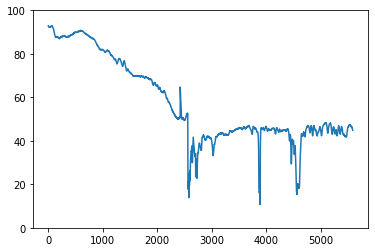

In [86]:
# for i, row in atl06_data.iterrows():
row = atl06_data.iloc[40]

#display(row)

# arc.find_the_rifts line 262
# arc.get_rifts 350
rift_list = arc.find_the_rifts(row["h"] - row["geoid"]- row["tides"])
#rift_list = arc.find_the_rifts(row['h'])
#rift_list = arc.get_rifts(row['h'])
print(rift_list)

import matplotlib.pyplot as plt
plt.plot(row['h'])
plt.ylim((0,100))

rift detector found 2 rifts
(3878, 3889)
(4562, 4563)


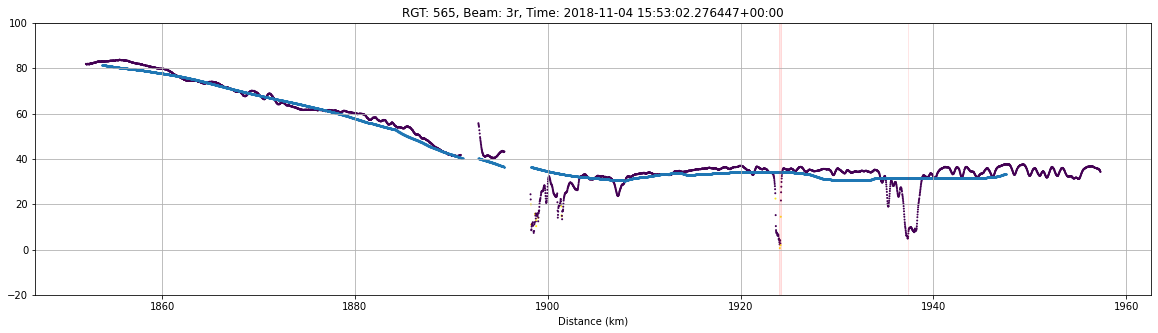

In [83]:
# plot to look like QC

from matplotlib.patches import Rectangle

fig,ax=plt.subplots(figsize=(20,5))

d = np.sqrt(row["x"]**2 + row["y"]**2) / 1000 #distance in km
h = row["h"] - row["geoid"]- row["tides"]

# make a rolling average
# May want to exclude quality flag 1
# or do we exclude things with large jumps? (>200m?)
# platelet is 40m, half overlapping
# 1km either side (2km) = 100, 10 km (20km) 1000 etc

# could use something more advanced

# Potential problem here is going to be the ends
# near grounding line and calving front that are cut off
# and get larger as the smoothing distance increases

def running_mean(x,N):
    cumsum = np.cumsum(np.insert(x,0,0))
    return(cumsum[N:] - cumsum[:-N]) / float(N)

run_length = 1000
h_run = running_mean(h,run_length+1)
d_run = d[int(run_length/2):int(len(d)-(run_length/2))]

#plt.scatter(d,row["h"],c=row["quality"])
plt.scatter(d,h,s=1,c=row["quality"])
plt.scatter(d_run,h_run,s=1)


plt.title('RGT: %i, Beam: %s, Time: %s'%(row["rgt"],row["beam"],row["time"]))
plt.xlabel('Distance (km)')

plot_min = -20
plot_max = 100

nr_rifts = len(rift_list)
print("rift detector found " + str(nr_rifts) + " rifts")

for rift in rift_list:
    print(rift)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                edgecolor = 'red',
                facecolor = 'red',
                alpha = 0.1))

plt.ylim((plot_min,plot_max))
#plt.xlim(1890,1900)
plt.grid()
plt.show()

Zoom in on the detected rifts

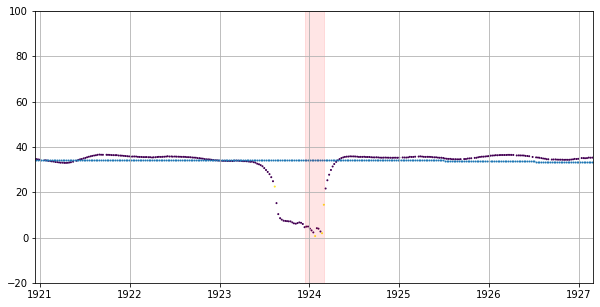

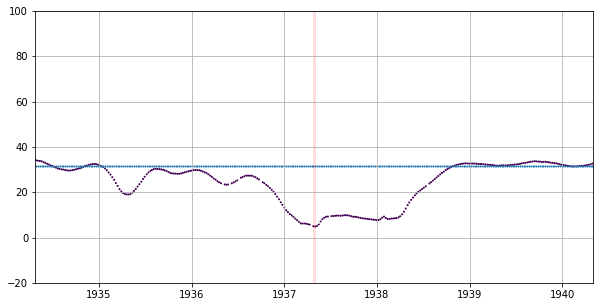

In [84]:
from matplotlib.patches import Rectangle

# make plot zoomed in on each rift (up to max_plots)
dist_around_rift = 3 #km
max_plots = 3
if len(rift_list) < max_plots:
    max_plots = len(rift_list)

# loop through plotting approx. 5 km either side of detected rift

plot_min = -20
plot_max = 100

i=0 #initialise
for rift in rift_list:
    i += 1
    if i > max_plots:
        break
    fig,ax=plt.subplots(figsize=(10,5))
    plt.scatter(d,h,s=1,c=row["quality"])
    plt.scatter(d_run,h_run,s=1)
    rift_start = rift[0]
    rift_end   = rift[1]
    dist_start = d[rift_start]
    dist_end   = d[rift_end]
    dist_rift  = dist_end - dist_start
    ax.add_patch(Rectangle((dist_start,plot_min),dist_rift,plot_max-plot_min,
                           edgecolor = 'red',
                           facecolor = 'red',
                           alpha = 0.1))
    plt.xlim((dist_start-dist_around_rift,dist_end+dist_around_rift))
    plt.ylim((plot_min,plot_max))
    plt.grid()
    plt.show()
    
    
    